# Akhmetzhanov Ravil, MS-RO-21.
# r.akhmetzhanov@innopolis.university

# Task - Human iris center calculation

This task was written and compiled in Kaggle, because of very fast GPU. Link to the Kaggle project: https://www.kaggle.com/ravilakhmetzhanov/innopolis-machine-learning-a2-task-3

Link to the dataset: https://www.unavarra.es/gi4e/databases/gi4e/

# Importing necessary modules

In [ ]:
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

import scipy.ndimage as sci
import matplotlib.pyplot as plt

# Dataset preprocessing

In [ ]:
# Reading files
N_of_People = 103
N_of_Photos = 12 

data_photo = []
str_data_labels = []

# This is path to Kaggle dataset
# If you run this in on your machine - change path
photo_path = '../input/gi4e-gaze-interaction-for-everybody/images'
labels_path = '../input/gi4e-gaze-interaction-for-everybody/labels'

for i in range(N_of_People):
    photo_list = []
    frac_label_list = []
    # Reading .txt labels
    if i < 9:
      txt_path = labels_path + f'/00{i+1}_image_labels.txt'
      png_1 = f'/00{i+1}'
    elif 9 >= i < 99:
      txt_path = labels_path + f'/0{i+1}_image_labels.txt'
      png_1 = f'/0{i+1}'
    elif i >= 99:
      txt_path = labels_path + f'/{i+1}_image_labels.txt'
      png_1 = f'/{i+1}'
    with open(txt_path, 'r') as f:
        label_list = f.readlines()
    for j in range(N_of_Photos):
        frac_label_list.append(label_list[j].split()[1:])
        # Reading an .png image and converting it to GrayScale
        if j < 9:
          png_2 = f'_0{j+1}.png'
        elif j>= 9:
          png_2 = f'_{j+1}.png'
        png_path = photo_path + png_1 + png_2
        photo_list.append(cv.imread(png_path, cv.IMREAD_GRAYSCALE)) 
    str_data_labels.append(frac_label_list)
    data_photo.append(photo_list)

str_data_labels = np.array(str_data_labels)
float_data_labels = str_data_labels.astype(float)

data_labels = float_data_labels.astype(int)
data_photo = np.array(data_photo)


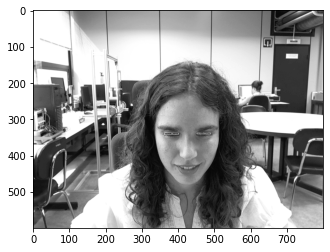

In [ ]:
# Test: Finding eyes and irises on an arbitrary photo

u = 0     # User number
p = 0     # Photo number

example = data_photo[u][p].copy()

# left eye
cv.rectangle(example, (data_labels[u][p][0], data_labels[u][p][1]), (data_labels[u][p][4],  data_labels[u][p][5]), (255, 0, 0), thickness=1 ) 
cv.circle(example, (data_labels[u][p][2], data_labels[u][p][3]), 1, (255,0,0), thickness=-1)

# right eye
cv.rectangle(example, (data_labels[u][p][6], data_labels[u][p][7]), (data_labels[u][p][10], data_labels[u][p][11]), (255, 0, 0), thickness=1 )
cv.circle(example, (data_labels[u][p][8], data_labels[u][p][9]), 1, (255,0,0), thickness=-1)

plt.imshow(example, cmap = 'gray')

In [ ]:
data_photo = data_photo.reshape(103*12,600,800)
data_labels = data_labels.reshape(103*12,12)

blank = np.zeros((600,800), dtype='uint8')
x = []
y = []

# Cropping data_sets:
for i in range(N_of_People * N_of_Photos):
  # LEFT eye
  l_center_x = data_labels[i][0] - abs(data_labels[i][0] - data_labels[i][4]) // 2
  l_center_y = data_labels[i][1] - abs(data_labels[i][1] - data_labels[i][5]) // 2
  left_eye = data_photo[i][l_center_y -24 : l_center_y + 24  , l_center_x - 24: l_center_x + 24 ] 
  x.append(left_eye)

  l_iris_x = data_labels[i][2] - (l_center_x - 24)
  l_iris_y = data_labels[i][3] - (l_center_y - 24)
  left_eye_iris = blank.copy()[l_center_y - 24 : l_center_y + 24  , l_center_x - 24: l_center_x + 24 ]
  left_eye_iris[l_iris_x, l_iris_y] = 255
  left_eye_iris = sci.gaussian_filter(left_eye_iris, sigma = 1)
  left_eye_iris = left_eye_iris * 4    # Increasing intencity
  y.append(left_eye_iris)

  # RIGHT eye
  r_center_x = data_labels[i][6] - abs(data_labels[i][10] - data_labels[i][6]) // 2
  r_center_y = data_labels[i][7] - abs(data_labels[i][11] - data_labels[i][7]) // 2
  right_eye = data_photo[i][r_center_y - 24 : r_center_y + 24  , r_center_x - 24: r_center_x + 24 ]
  x.append(right_eye)

  r_iris_x = data_labels[i][8] - (r_center_x - 24)
  r_iris_y = data_labels[i][9] - (r_center_y - 24)
  right_eye_iris = blank.copy()[r_center_y - 24 : r_center_y + 24  , r_center_x - 24: r_center_x + 24 ]
  right_eye_iris[r_iris_x, r_iris_y] = 255
  right_eye_iris = sci.gaussian_filter(right_eye_iris, sigma = 1)
  right_eye_iris = right_eye_iris * 4     # Increasing intencity
  y.append(right_eye_iris)
 
x = np.array(x)
y = np.array(y)

print(x.shape, y.shape)

(2472, 48, 48) (2472, 48, 48)


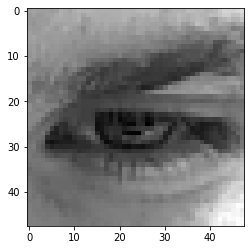

In [ ]:
plt.imshow(x[0], cmap = 'gray')

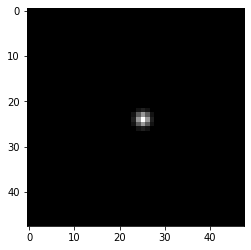

In [ ]:
plt.imshow(y[0], cmap = 'gray')

In [ ]:
# Normalization
x = x/255
y = y/255

In [ ]:
# Shuffling and splitting

np.random.shuffle(x)
x_train, x_test = x[:1980], x[1980:]
y_train, y_test = y[:1980], y[1980:]

# Turn into tensors
x_train = torch.Tensor(x_train[:, np.newaxis] )
x_test = torch.Tensor(x_test[:, np.newaxis] )
y_train = torch.Tensor(y_train[:, np.newaxis] )
y_test = torch.Tensor(y_test[:, np.newaxis] )

In [ ]:
x_train.shape

torch.Size([1980, 1, 48, 48])

In [ ]:
# Turning into Dataloader
# This is the most comfortable format for Neural Network Training
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)
train_ds = DataLoader(train_ds, 10)
test_ds = DataLoader(test_ds, 10)

# Building CNN

Creating class for CNN

Network Architecture is taken from Figure 3 of the following paper: https://ieeexplore.ieee.org/abstract/document/8803121

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 3, padding = 1)               # 48*48
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1) 

        # MaxPool is needed to reduce dimensions by 2
        self.pool1 = nn.MaxPool2d(2, stride = 2)                       # 24*24
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, stride = 2)                        # 12*12
        self.conv4 = nn.Conv2d(128, 64, 3, padding = 1)
        self.conv5 = nn.Conv2d(64, 1, 3, padding = 1)

        self.t_conv1 = nn.ConvTranspose2d(256, 64, 3, stride = 5, padding = 5)
        self.t_conv2 = nn.ConvTranspose2d(256, 128, 3, stride = 3, padding = 6)
        self.t_conv3 = nn.ConvTranspose2d(128, 64, 3, stride = 3, padding = 12)
        self.t_conv4 = nn.ConvTranspose2d(64, 1, 3, stride=1, padding = 1)

    def forward(self, x, a_func):
        # x is for Base network
        x = a_func(self.conv1(x))

        # creating Skip Connection
        x_skip = x                                                    
        x = a_func(self.pool1(self.conv2(x)))
        x = a_func(self.pool2(self.conv3(x)))
        # y is for Auxiliary network
        y = x
        x = a_func(self.t_conv1(y))

        # Concatting x and skip connection signal
        x = torch.cat((x, x_skip), 1)
        x = a_func(self.conv4(x))

        # Sigmoid is used at the end of Base and Auxiliary network.
        # Because it improves the performance 
        # It was choosen after several trials
        x = F.sigmoid(self.conv5(x))

        y = a_func(self.t_conv2(y))
        y = a_func(self.t_conv3(y))
        y = F.sigmoid(self.t_conv4(y))
        return x, y

# Turning on GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_cnn = Net().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of params in the CNN model:", count_parameters(model_cnn))

Number of params in the CNN model: 960962


Functions for training and testing

In [ ]:
def train( model, device, train_loader, a_func, loss_func, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output_1, output_2 = model(data, a_func)

        # loss - is our custom loss function
        
        # loss_1 is for base network
        # it takes into account only cropped part of 48*48 image: [12:36, 12:36]
        # Because iris will always be in this area and we care only about it
        loss_1 = loss_func(output_1[:,:,12:36,12:36], target[:,:,12:36,12:36]) 
        loss_2 = loss_func(output_2, data) 
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()
    return loss.item()
            
def test( model, device, a_func, loss_func, test_loader):
    model.eval()
    test_loss, loss1, loss2 = 0,0,0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output_1, output_2  = model(data, a_func)
            loss1 += loss_func(output_1[:,:,12:36,12:36], target[:,:,12:36,12:36], reduction = 'sum').item() 
            loss2 += loss_func(output_2, data, reduction = 'sum').item() 

    test_loss = loss1 + loss2
    test_loss /= len(test_loader.dataset) * 10
 
    return test_loss

# Choosing parameters


Applying self-made GridSearch for finding best combination of Optimizer + Activation + Loss function

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Results for Adam + relu + mse_loss: train_error = 0.00264, test_error = 0.48231 

Results for Adam + relu + l1_loss: train_error = 0.0199, test_error = 5.40829 



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Results for Adam + tanh + mse_loss: train_error = 0.00226, test_error = 0.4661 

Results for Adam + tanh + l1_loss: train_error = 0.01611, test_error = 4.67993 

Results for Adam + sigmoid + mse_loss: train_error = 0.00767, test_error = 2.0042 

Results for Adam + sigmoid + l1_loss: train_error = 0.0729, test_error = 14.02228 

Results for Adamax + relu + mse_loss: train_error = 0.0029, test_error = 0.58971 

Results for Adamax + relu + l1_loss: train_error = 0.0222, test_error = 6.03149 

Results for Adamax + tanh + mse_loss: train_error = 0.00254, test_error = 0.49966 

Results for Adamax + tanh + l1_loss: train_error = 0.01807, test_error = 4.91425 

Results for Adamax + sigmoid + mse_loss: train_error = 0.01202, test_error = 3.10525 

Results for Adamax + sigmoid + l1_loss: train_error = 0.07729, test_error = 16.79849 

Results for RMSprop + relu + mse_loss: train_error = 0.18485, test_error = 50.55141 

Results for RMSprop + relu + l1_loss: train_error = 0.40144, test_error = 99.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Results for SGD + tanh + l1_loss: train_error = 0.09817, test_error = 23.58771 

Results for SGD + sigmoid + mse_loss: train_error = 0.02741, test_error = 7.63538 

Results for SGD + sigmoid + l1_loss: train_error = 0.12863, test_error = 32.06539 



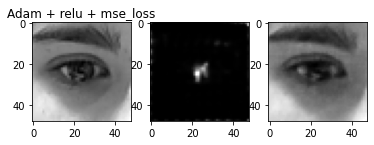

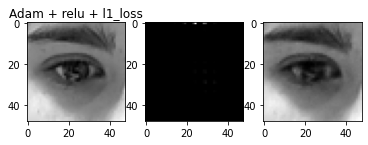

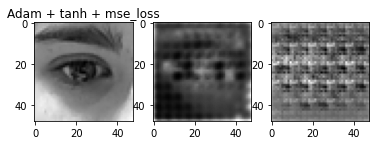

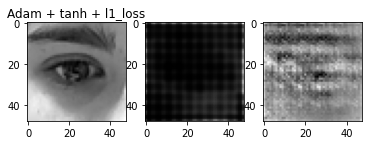

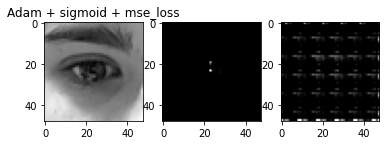

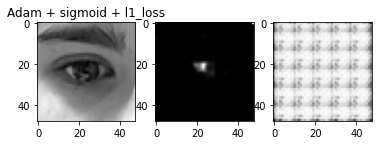

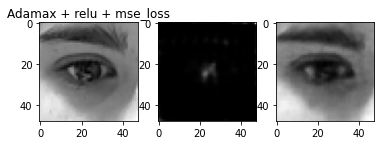

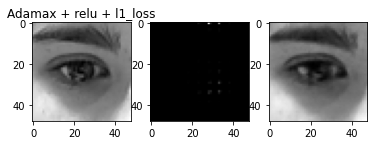

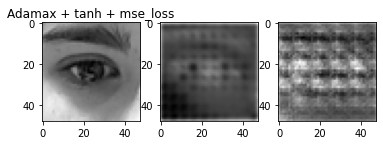

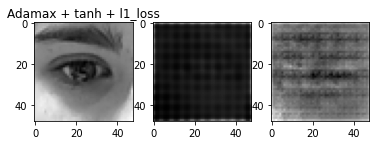

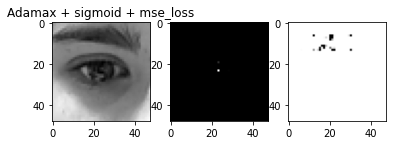

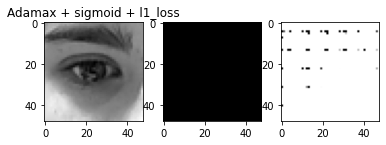

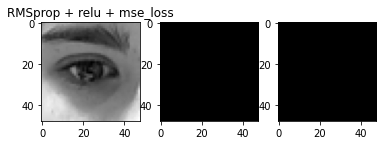

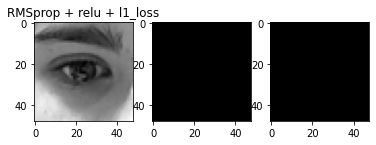

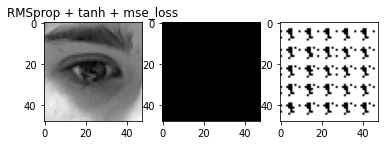

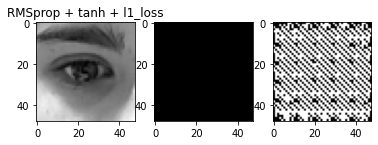

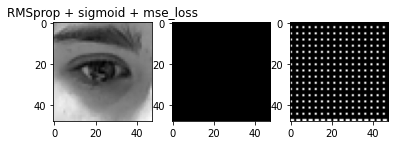

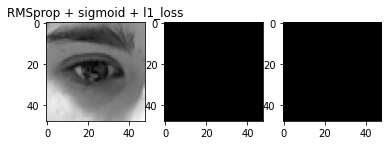

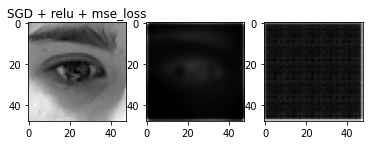

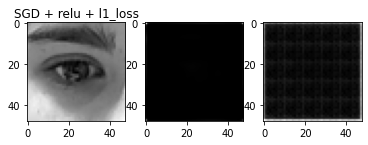

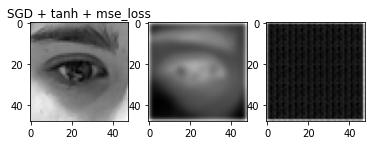

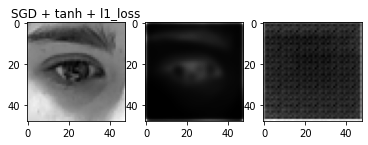

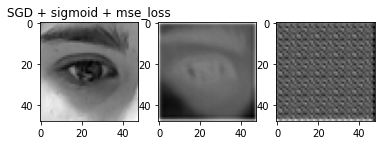

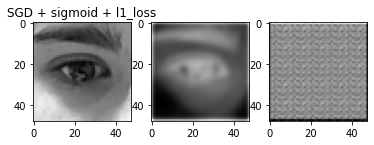

In [ ]:
optimizers = [optim.Adam, optim.Adamax, optim.RMSprop, optim.SGD]
activations = [F.relu, F.tanh, F.sigmoid]
loss_functions = [F.mse_loss, F.l1_loss]

epochs = 15
lr = 0.01
momentum = 0.5
log_interval = 700

for i in optimizers:
  for j in activations:
    for k in loss_functions:
      tr_error, test_error = [], []
      final_model = Net().to(device)
      if i == optim.SGD:
        optimizer = i(final_model.parameters(), lr=lr, momentum = momentum)
      else:
        optimizer = i(final_model.parameters())
      for epoch in range(1, epochs + 1):
        tr_error.append(train(final_model, device, train_ds, j, k, optimizer, epoch))
        test_error.append(test(final_model, device, j, k, test_ds))
      min_tr_e = min(tr_error)
      min_test_e = min(test_error)
      print(f'Results for {i.__name__} + {j.__name__} + {k.__name__}: train_error = {round(min_tr_e, 5)}, test_error = {round(min_test_e, 5)} \n')
      final_model.eval()
      with torch.no_grad():
        for data, target in test_ds:
          data, target = data.to(device), target.to(device)
          iris, remake  = final_model(data, F.relu)
          fig, axis = plt.subplots(1, 3)
          axis[0].imshow(data.cpu().detach()[0][0], cmap="gray")
          axis[0].set_title(f'{i.__name__} + {j.__name__} + {k.__name__}')
          axis[1].imshow(iris.cpu().detach()[0][0], cmap="gray")
          axis[2].imshow(remake.cpu().detach()[0][0], cmap="gray")
          break


# Best combination: Adam + MSE + tanh

---



Adam + MSE + tanh combination has the lowest value of test error. But image after 15 epoch doesn't look good. Let's increase the number of epochs.

In [ ]:
epochs = 40

# training CNN model
model_cnn = Net().to(device)
model = model_cnn
optimizer = optim.Adam(model.parameters())

tr_error, test_error = [], []

for epoch in range(1, epochs + 1):
    tr_error.append(train(model, device, train_ds, F.tanh, F.mse_loss, optimizer, epoch))
    test_error.append(test(model, device, F.tanh, F.mse_loss, test_ds))

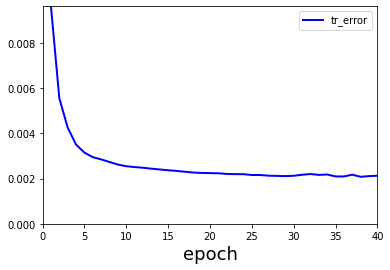

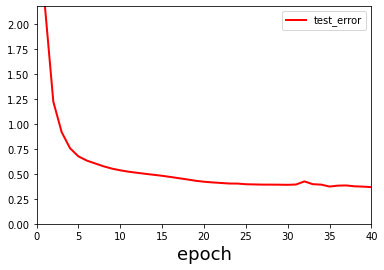

In [ ]:
epoch_list = np.arange(1,epochs + 1)

# Printing error graph

plt.figure()
plt.plot(epoch_list,tr_error, linewidth=2, color = 'blue', label="tr_error")
plt.xlabel('epoch', fontsize=18)
plt.xlim([0, max(epoch_list)])
plt.ylim([0,max(tr_error)])
plt.legend()
plt.show()

plt.figure()
plt.plot(epoch_list,test_error, linewidth=2, color = 'red', label="test_error")
plt.xlabel('epoch', fontsize=18)
plt.xlim([0, max(epoch_list)])
plt.ylim([0,max(test_error)])
plt.legend()
plt.show()

Appying iris detection for 10 images

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


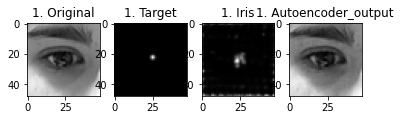

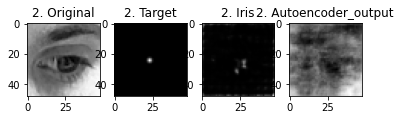

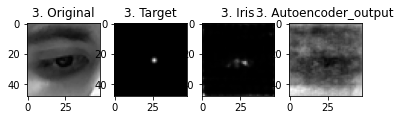

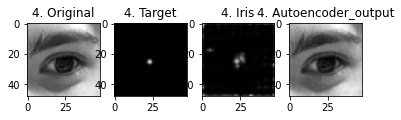

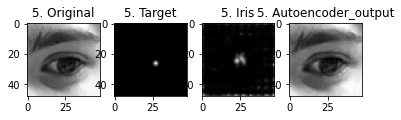

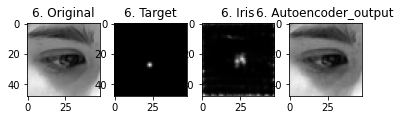

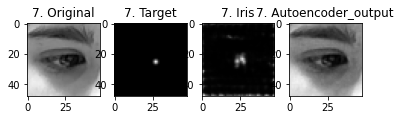

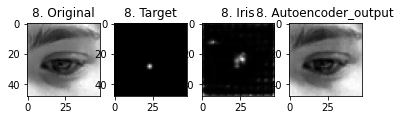

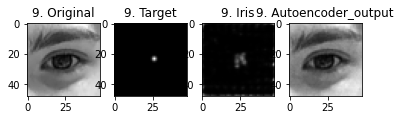

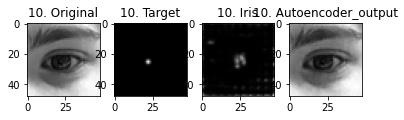

In [ ]:
model.eval()
with torch.no_grad():
  for data, target in test_ds:
    data, target = data.to(device), target.to(device)
    iris, remake  = model(data, F.tanh)
    for i in range(10):
      fig, axis = plt.subplots(1, 4)
      axis[0].imshow(data.cpu().detach()[i][0], cmap="gray")
      axis[0].set_title(f'{i+1}. Original')
      axis[1].imshow(target.cpu().detach()[i][0], cmap="gray")
      axis[1].set_title(f'{i+1}. Target')
      axis[2].imshow(iris.cpu().detach()[i][0], cmap="gray")
      axis[2].set_title(f'{i+1}. Iris')
      axis[3].imshow(remake.cpu().detach()[i][0], cmap="gray")
      axis[3].set_title(f'{i+1}. Autoencoder_output')
    break

Trained CNN can find iris, but the resulted iris is much more blured, than in the target

Also, sometimes, auxiliary network can't reconstruct the original image.

# Drawing Iris Center

For drawing iris center on the eye image we can calculate max value index on the predicted iris. 

This will be an iris center

In [ ]:
max_list = []
photo_list = []
for i in range(10):
    # Finding index of max value picture pixel
    j = int(torch.argmax(iris[i,0,12:36,12:36]))
    max_list.append(np.unravel_index(j, (24,24)))
    ex = np.array(data.cpu().detach()[i][0])
    photo_list.append(ex)
print(max_list)

[(12, 11), (13, 15), (14, 16), (13, 11), (12, 11), (11, 14), (11, 14), (11, 14), (11, 14), (10, 14)]


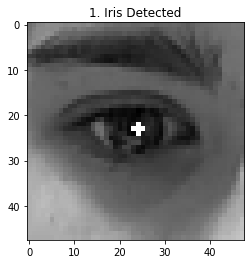

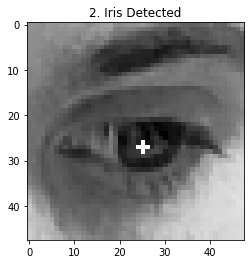

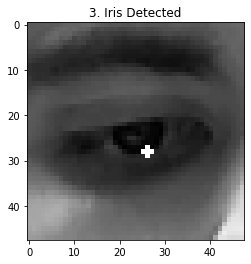

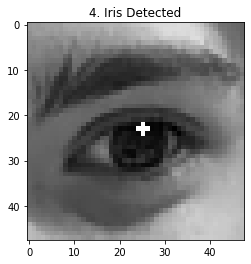

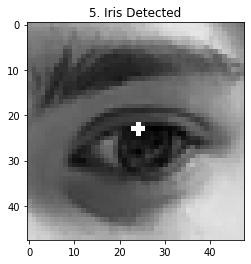

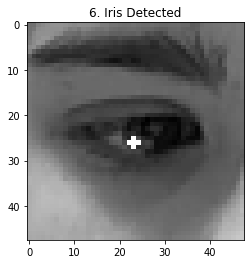

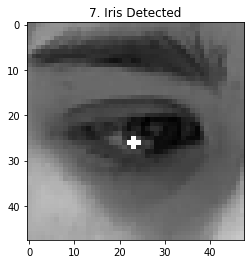

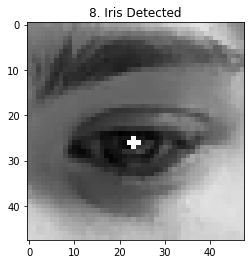

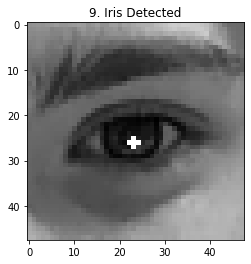

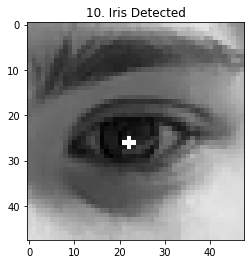

In [ ]:
for i in range(10):
    cv.circle(photo_list[i][12:36,12:36], (max_list[i][0], max_list[i][1]), 1, (1,0,0), thickness=-1)
    fig, axis = plt.subplots(1, 1)
    axis.imshow(photo_list[i], cmap="gray")
    axis.set_title(f'{i+1}. Iris Detected')

Our model has good performance, in general. But sometimes it  produces an error of cevertal pixels.